## Objective

You are a data scientist for a top movie studio.

After a series of box office flops, the producers at your
studio are starting to question their strategy and need a new direction. 

You suggest a new approach -
using data to determine what factors go into making a successful film.

Luckily, you have a dataset of over 5,000 films to mine for insights! The producers ask you to analyze the
data and present a report detailing your findings and recommendations on revamping the studio’s
strategy.

## Data
Attached is The Zebra movie dataset for use.
**Data Dictionary (selected columns)**
* num_critic_reviews - number of movie reviews written by critics
* num_user_reviews - number of movie reviews written by IMDB users
* num_users_voted - number of IMDB users that rated the film
* duration - the length of the film in minutes
* actor_n_facebook_likes - the number of likes on the actor’s Facebook page (we can assume this was
* measured before the film was released)
* gross - the film’s gross revenue
* movie_score - the film’s rating on a 1-10 scale by users that voted

### GOAL
* only supposed to spend **6-8 hours** on this

### Planned Breakdown
* **1 hour** setup (power point starter and code set)
  * includes some basic time for understanding
* 3 key insights - **4 hours**
* what we could explore, next steps, code checking, **1 hour**
* presentation build and script build and practice **2 hours**

In [1]:
# !pip install missingno # only used for this shouldn't be in requirements
# !pip install pingouin

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import pandas as pd
import pingouin as pg # gives confidence intervals with estimates
import seaborn as sns

sys.path.append("..")
from src.make_data import get_long_text_summary


sys.tracebacklimit = 0 # easier to see problems
plt.rcParams["figure.figsize"] = (12, 8)


## Load Data

In [3]:

df = pd.read_csv("..//data/raw/the_zebra_movie_data.csv")

print(df.shape)
df.head(3).T

(5043, 26)


,0,1,2
color,Color,Color,Color
director_name,James Cameron,Gore Verbinski,Sam Mendes
num_critic_reviews,723.0,302.0,602.0
duration,178.0,169.0,148.0
director_facebook_likes,0.0,563.0,0.0
actor_3_facebook_likes,855.0,1000.0,161.0
actor_2_name,Joel David Moore,Orlando Bloom,Rory Kinnear
actor_1_facebook_likes,1000.0,40000.0,11000.0
gross,760505847.0,309404152.0,200074175.0
genres,Action|Adventure|Fantasy|Sci-Fi,Action|Adventure|Fantasy,Action|Adventure|Thriller


In [4]:
# fair amount of nulls  -- dive further on those
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_reviews         4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_users_voted            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

In [5]:
# will need lift
df = df.assign(lift = (df["gross"] / df["budget"]))

df.sort_values("lift", ascending=False)[["movie_title", "lift", "gross", "budget"]]

,movie_title,lift,gross,budget
4793,Paranormal Activity,7194.485533,107917283.0,15000.0
4799,Tarnation,2715.660550,592014.0,218.0
4707,The Blair Witch Project,2342.168567,140530114.0,60000.0
4984,The Brothers McMullen,409.864000,10246600.0,25000.0
3278,The Texas Chain Saw Massacre,369.427285,30859000.0,83532.0
...,...,...,...,...
5036,The Mongol King,NaN,NaN,3250.0
5038,Signed Sealed Delivered,NaN,NaN,NaN
5039,The Following,NaN,NaN,NaN
5040,A Plague So Pleasant,NaN,NaN,1400.0


## Profile Some Missing Data

In [6]:
# check the percent missing
# a note: facebook likes as 0 could also be a null, same for reviews and everything else
# would need to go to the source and understand them better

df.style.background_gradient()

df_zeros = df.replace(0, np.nan)

pd.concat([(df.isnull().sum() / len(df) * 100).to_frame(name="raw_nulls"),
            (df_zeros.isnull().sum() / len(df_zeros) * 100).\
            to_frame(name="with_zeros")], axis=1).sort_values(by="with_zeros", ascending=False) # zeros should be strictly greater than


,raw_nulls,with_zeros
movie_facebook_likes,0.000000,43.248067
lift,22.843546,22.843546
director_facebook_likes,2.062265,20.047591
gross,17.529248,17.529248
budget,9.756098,9.756098
aspect_ratio,6.523895,6.523895
content_rating,6.008328,6.008328
plot_keywords,3.033908,3.033908
actor_3_facebook_likes,0.456078,2.220900
title_year,2.141582,2.141582


***

Data we definitely have - genres, num_users_voted, movie_title, movie_score

Data missing we should explore a bit, title_year, gross, budget

<Axes: >

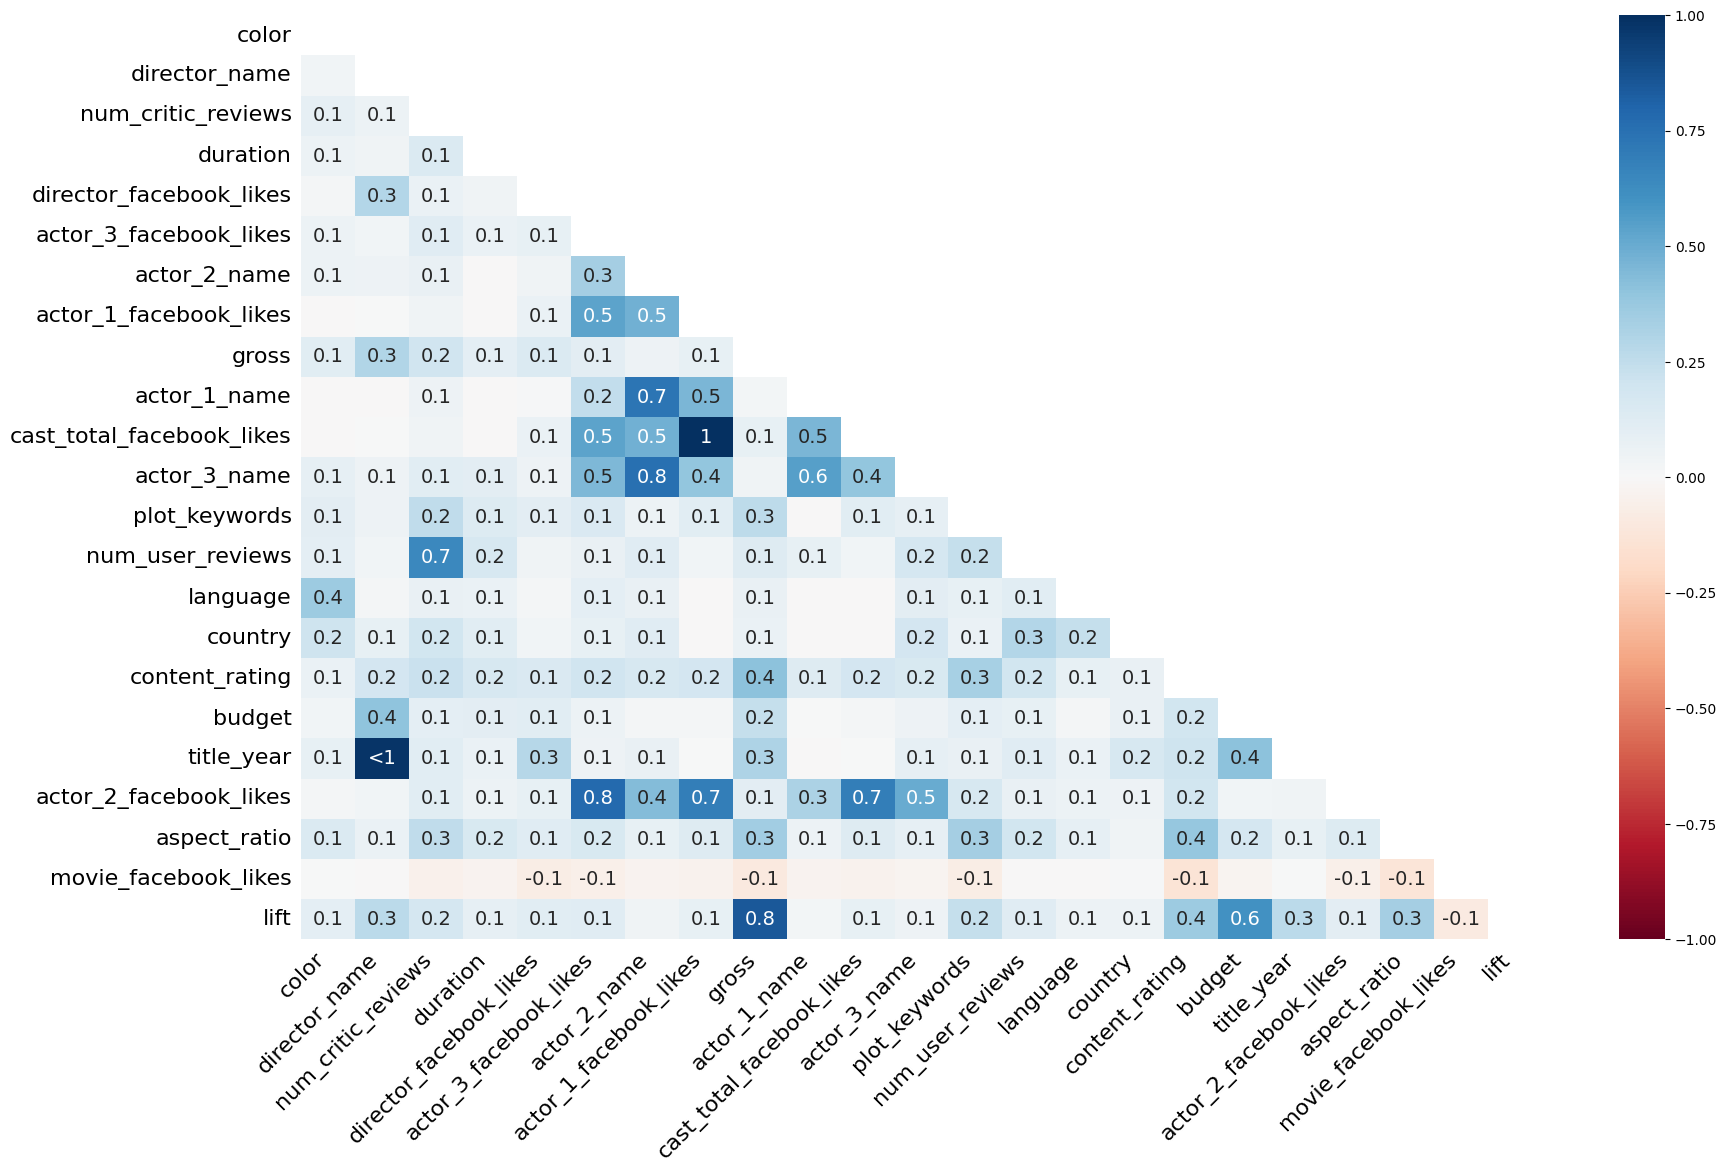

In [7]:
msno.heatmap(df_zeros)

## Exploring Genre 

In [8]:
df.genres.head()

0    Action|Adventure|Fantasy|Sci-Fi
1           Action|Adventure|Fantasy
2          Action|Adventure|Thriller
3                    Action|Thriller
4                        Documentary
Name: genres, dtype: object

In [9]:
# also have the same format for plot k-w
df.plot_keywords.head()

0               avatar|future|marine|native|paraplegic
1    goddess|marriage ceremony|marriage proposal|pi...
2                  bomb|espionage|sequel|spy|terrorist
3    deception|imprisonment|lawlessness|police offi...
4                                                  NaN
Name: plot_keywords, dtype: object

In [10]:
get_long_text_summary(df, "genres").sort_values("n", ascending=False).head(10)


,n,num_voted,movie_score,movie_score_median
kw_clean,,,,
Drama,2594,77409.06,6.76,6.9
Comedy,1872,63726.90,6.20,6.3
Thriller,1411,94181.91,6.31,6.4
Action,1153,124957.96,6.24,6.3
Romance,1107,66246.37,6.45,6.5
Adventure,923,140009.65,6.44,6.6
Crime,889,92451.46,6.56,6.6
Sci-Fi,616,141976.32,6.28,6.4
Fantasy,610,118254.19,6.31,6.4


In [11]:
get_long_text_summary(df, "plot_keywords")

,n,num_voted,movie_score,movie_score_median
kw_clean,,,,
wrongful imprisonment,1,1689764.0,9.3,9.3
prison cell search,1,1689764.0,9.3,9.3
rise to power,1,1155770.0,9.2,9.2
moral challenge,2,12590.5,9.1,9.1
meaning of life,2,12590.5,9.1,9.1
...,...,...,...,...
science experiment,1,25371.0,1.9,1.9
cnn reporter,1,534.0,1.9,1.9
pun,1,4377.0,1.7,1.7


## Movie Year

*  Understand where its missing
*  seems both random and for movies that are still in theaters (Force awakens came out end of 2015 and data through 2016 )

In [12]:

print("We have Movie data from {} to {}".format(df["title_year"].min().astype(int), df["title_year"].max().astype(int)))



We have Movie data from 1916 to 2016


In [13]:
## what titles don't have years

df_null = df_zeros.loc[df["title_year"].isnull(), :]

print(df_null.shape, df.shape) # sanity check (108, 5k)

df_null["movie_title"] 

df_null.sort_values("num_users_voted", ascending=False)[["movie_title", "num_users_voted", "movie_score", "gross"]]
 # seems like some popular movies and some recent

(108, 27) (5043, 27)


,movie_title,num_users_voted,movie_score,gross
459,Daredevil,213483,8.8,NaN
4798,Heroes,202115,7.7,NaN
2952,Spartacus: War of the Damned,173172,8.6,NaN
3481,Fargo,170055,9.0,NaN
404,Hannibal,159910,8.6,NaN
...,...,...,...,...
2370,"Gone, Baby, Gone",29,6.6,NaN
2342,The Doombolt Chase,18,7.2,NaN
2765,Towering Inferno,10,9.5,NaN
4,Star Wars: Episode VII - The Force Awakens,8,7.1,NaN


In [14]:
# group by decades to get trend
def floor_to_decade(x):
  return np.floor(x / 10) * 10


df = df.assign(decade = df.title_year.fillna(9999).apply(floor_to_decade).astype(int))

In [15]:
tbl = df["decade"].value_counts().to_frame("count").reset_index().sort_values("decade",ascending=False)

In [16]:
tbl

,decade,count
5,9990,108
1,2010,1497
0,2000,2100
2,1990,786
3,1980,291
4,1970,114
6,1960,73
7,1950,28
8,1940,25
9,1930,15


In [17]:

tbl

,decade,count
5,9990,108
1,2010,1497
0,2000,2100
2,1990,786
3,1980,291
4,1970,114
6,1960,73
7,1950,28
8,1940,25
9,1930,15


In [34]:
tbl = df.groupby("decade").agg(
    n = ("movie_title", "count"),
    median_score = ("movie_score", "median"),
    avg_users_voted = ("num_users_voted", "mean"),
).round(2)

tbl = tbl.reset_index()

tbl

,decade,n,median_score,avg_users_voted
0,1980,291,6.8,79643.19
1,1990,786,6.6,89864.21
2,2000,2100,6.5,84930.80
3,2010,1497,6.4,84303.74


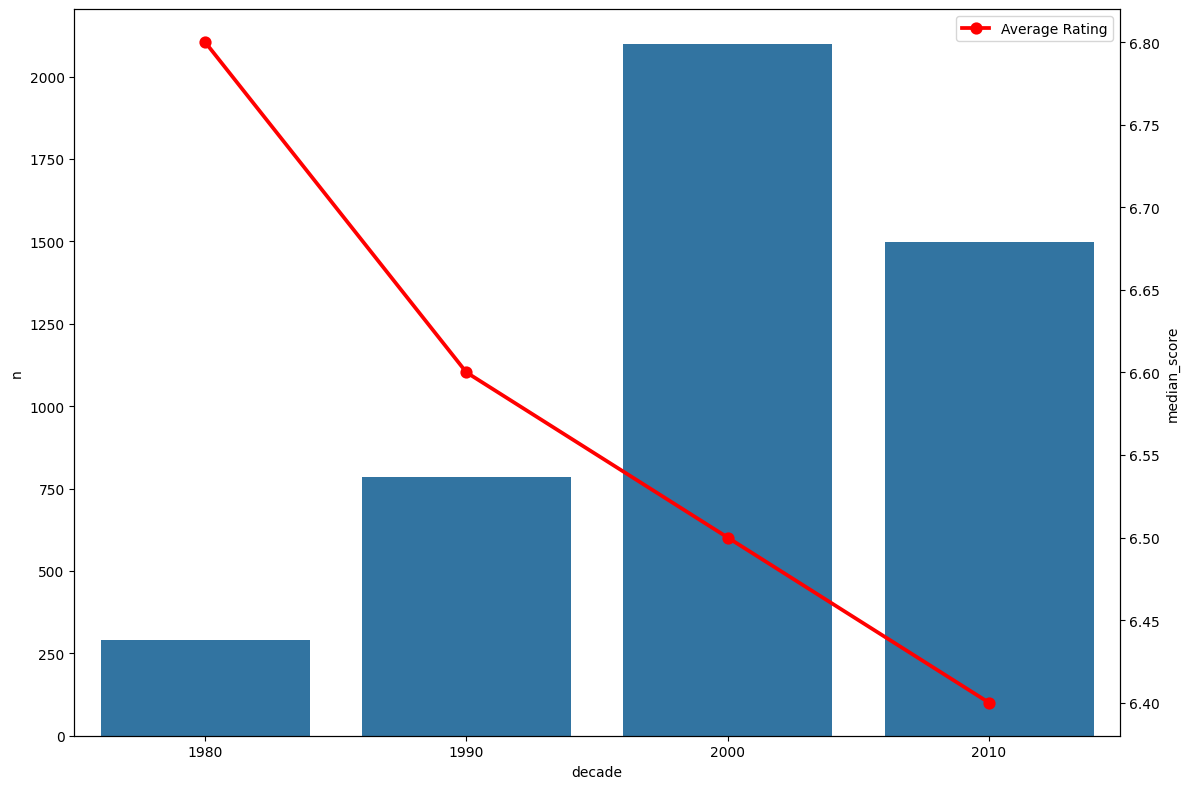

In [35]:

fig, ax = plt.subplots()
tbl["decade"] = tbl["decade"].astype(str).str.replace("9990", "N/As")

sns.barplot(data = tbl, x = "decade", y = "n", ax = ax).set(title = "")

ax2 = ax.twinx()
sns.pointplot(data = tbl, x="decade", y = "median_score", ax = ax2, color="red", label = "Average Rating")
# sns.hline(df["movie_score"].mean())  grand mean

plt.tight_layout()

# Show the plot
plt.show()

In [20]:
df_tmp = df.loc[df["lift"].notnull(), ]

tbl = df_tmp.groupby("decade").agg(
    n = ("movie_title", "count"),
    avg_score = ("movie_score", "mean"),
    avg_users_voted = ("num_users_voted", "mean"),
    median_lift = ("lift", "median"),
    median_gross = ("gross", "median")
)

tbl = tbl.reset_index()
tbl

,decade,n,avg_score,avg_users_voted,median_lift,median_gross
0,1920,3,6.466667,38797.333333,7.408971,2808000.0
1,1930,6,8.016667,134139.833333,6.584342,12601306.0
2,1940,6,7.516667,38473.000000,6.905952,22025000.0
3,1950,8,7.575000,84792.000000,8.834486,17300000.0
4,1960,25,7.652000,119337.680000,4.925532,32000000.0
5,1970,49,7.334694,177182.836735,7.172727,47000000.0
6,1980,216,6.691204,93017.504630,2.881326,33100000.0
7,1990,739,6.527199,94842.719892,1.143323,26616590.0
8,2000,1785,6.368627,96934.154062,0.915191,24004159.0
9,2010,1054,6.440892,116174.799810,1.041021,34994646.5


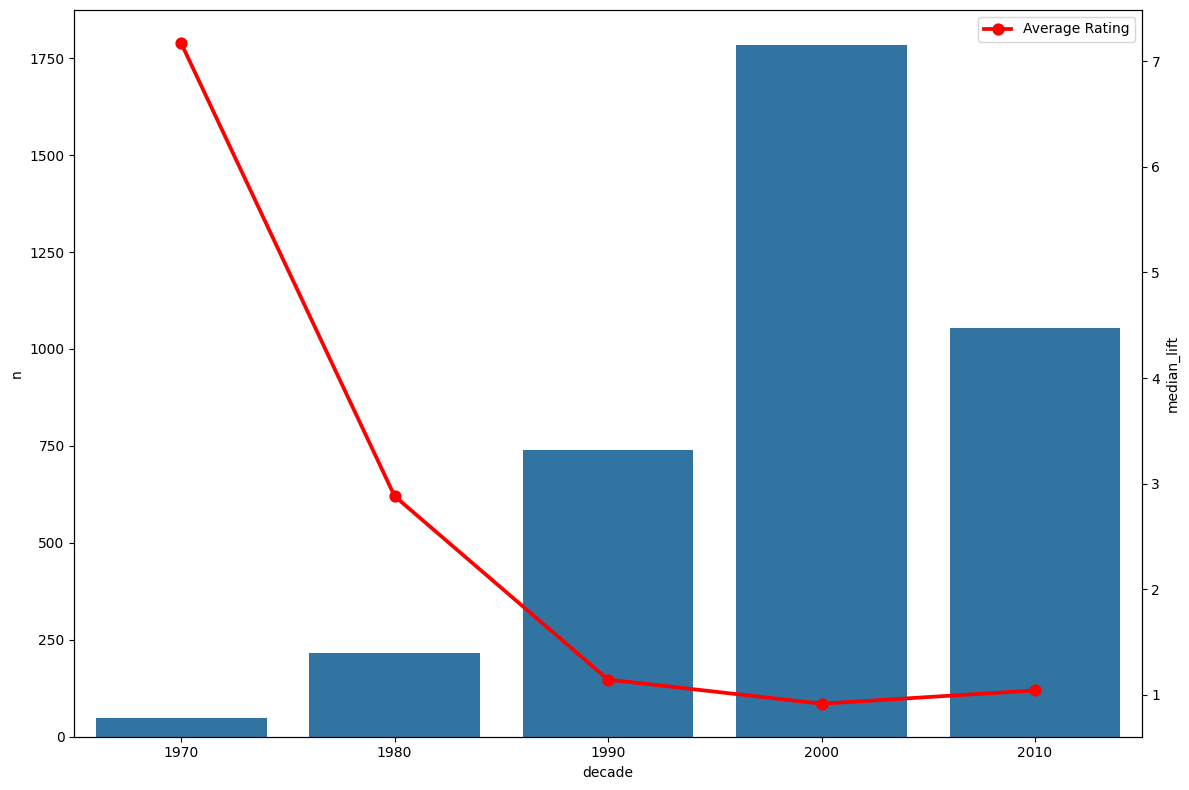

In [21]:

fig, ax = plt.subplots()
tbl["decade"] = tbl["decade"].astype(str).str.replace("9990", "N/As")

tbl = tbl.loc[tbl["decade"] >= "1970", ]
sns.barplot(data = tbl, x = "decade", y = "n", ax = ax).set(title = "")

ax2 = ax.twinx()
sns.pointplot(data = tbl, x="decade", y = "median_lift", ax = ax2, color="red", label = "Average Rating")
# sns.hline(df["movie_score"].mean())  grand mean

plt.tight_layout()

# Show the plot
plt.show()

In [22]:
df.loc[df["decade"] == 2010,:].dropna()[["movie_title", "lift", "gross", "budget"]]

,movie_title,lift,gross,budget
2,Spectre,0.816629,200074175.0,245000000.0
3,The Dark Knight Rises,1.792523,448130642.0,250000000.0
5,John Carter,0.277052,73058679.0,263700000.0
7,Tangled,0.772336,200807262.0,260000000.0
8,Avengers: Age of Ultron,1.835966,458991599.0,250000000.0
...,...,...,...,...
4964,Cheap Thrills,0.296895,59379.0,200000.0
4978,The FP,0.675950,40557.0,60000.0
4979,Happy Christmas,0.429771,30084.0,70000.0
4987,Tiny Furniture,5.996985,389804.0,65000.0


## Correlation Tests

In [23]:
pg.corr(x = df_zeros["title_year"], y=df_zeros["gross"])

,n,r,CI95%,p-val,BF10,power
pearson,4156,0.030886,"[0.0, 0.06]",0.046481,0.141,0.512517


In [24]:
pg.corr(x = df_zeros["budget"], y=df_zeros["gross"])

,n,r,CI95%,p-val,BF10,power
pearson,3891,0.102179,"[0.07, 0.13]",1.676128e-10,1.451e+07,0.999995


In [25]:
pg.corr(x = df_zeros["movie_score"], y=df_zeros["gross"])

,n,r,CI95%,p-val,BF10,power
pearson,4159,0.198021,"[0.17, 0.23]",4.834070e-38,2.4e+34,1.0


In [26]:
df["budget_log"] = np.log(df["budget"])
df["gross_log"] = np.log(df["gross"])


In [27]:
df.nunique().to_frame()

,0
color,2
director_name,2398
num_critic_reviews,528
duration,191
director_facebook_likes,435
actor_3_facebook_likes,906
actor_2_name,3032
actor_1_facebook_likes,878
gross,4035
genres,914


In [28]:
pg.corr(df["gross_log"], df["budget_log"])

,n,r,CI95%,p-val,BF10,power
pearson,3891,0.583861,"[0.56, 0.6]",0.0,inf,1.0


In [29]:
pg.corr(df["gross"], df["budget"])

,n,r,CI95%,p-val,BF10,power
pearson,3891,0.102179,"[0.07, 0.13]",1.676128e-10,1.451e+07,0.999995


<Axes: xlabel='budget_log', ylabel='gross_log'>

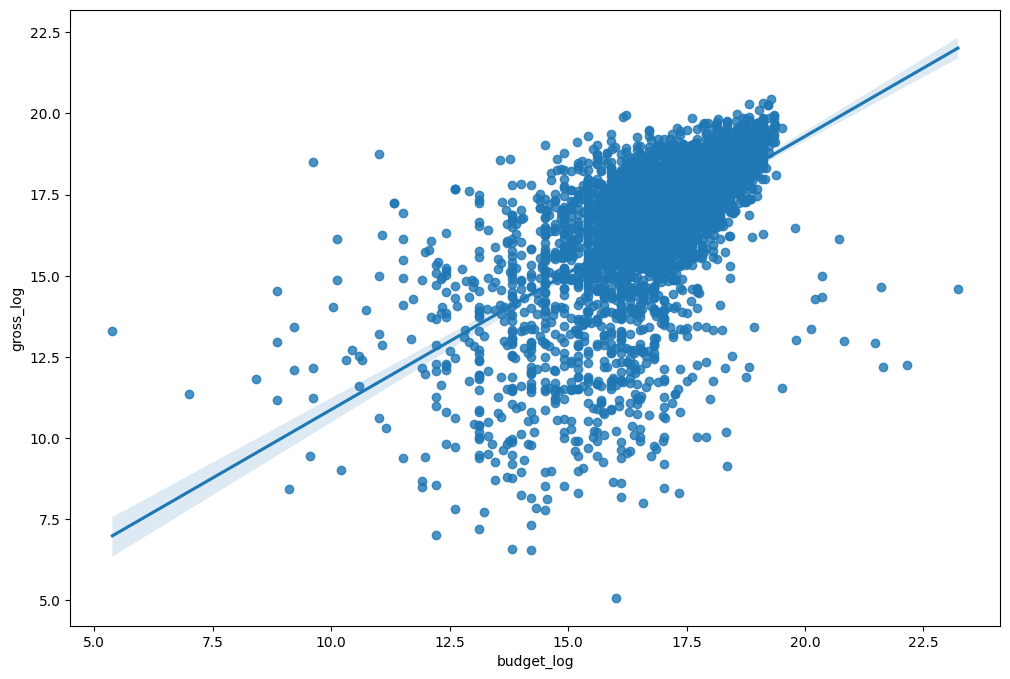

In [30]:
df = df.loc[df["decade"] < 2020]
sns.regplot(df, y="gross_log", x = "budget_log")

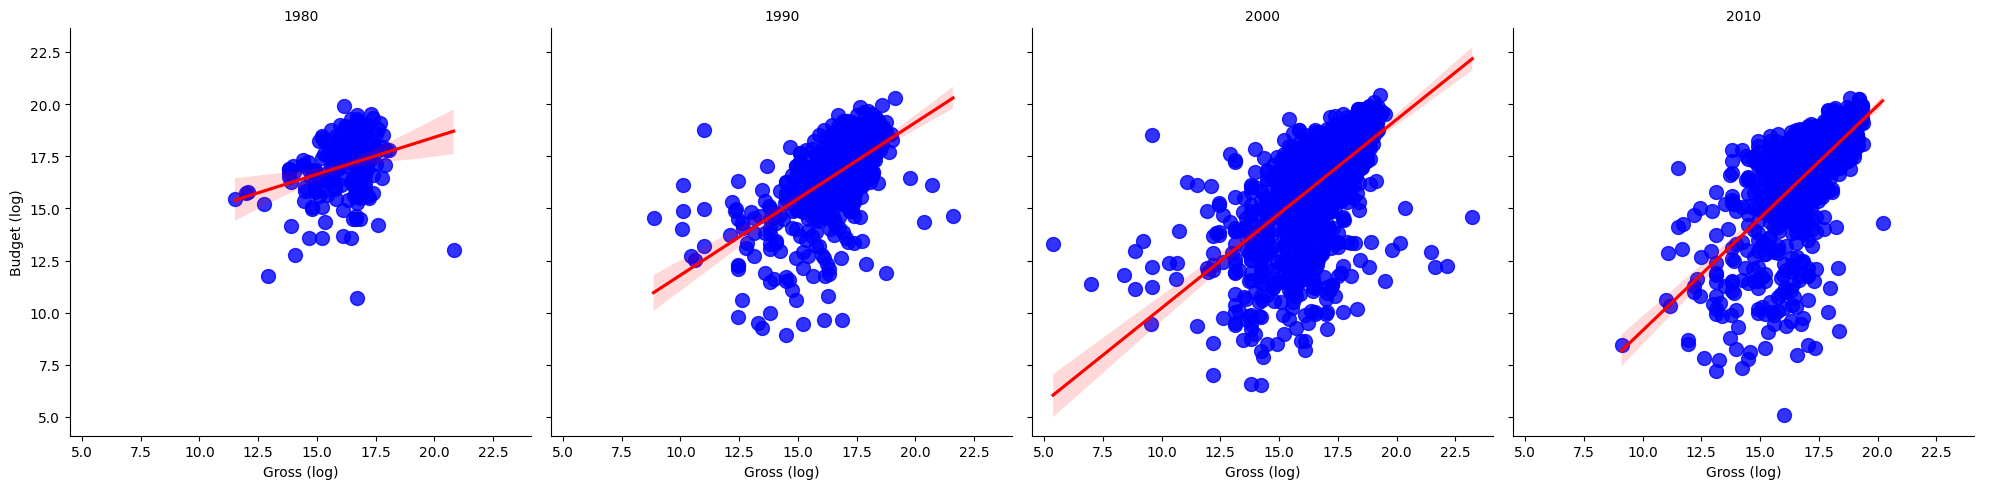

In [31]:
df = df.loc[df["decade"] > 1970]

# Create a FacetGrid
g = sns.FacetGrid(df, col="decade", height=5)

# Map the regplot to each facet
g.map(sns.regplot, "budget_log", "gross_log", scatter_kws={'s': 100, 'color': 'blue'}, line_kws={'color': 'red'})

# Adjust the plot
g.set_axis_labels("Gross (log)", "Budget (log)")
g.set_titles("{col_name}")
g.add_legend()

# Show the plot
plt.show()

In [32]:
# need to make long first

# # Create a FacetGrid
# g = sns.FacetGrid(tmp, col="genres", height=5)

# # Map the regplot to each facet
# g.map(sns.regplot, "budget_log", "gross_log", scatter_kws={'s': 100, 'color': 'blue'}, line_kws={'color': 'red'})

# # Adjust the plot
# g.set_axis_labels("Gross (log)", "Budget (log)")
# g.set_titles("{col_name}")
# g.add_legend()

# # Show the plot
# plt.show()